# pilot data probe

In [38]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [69]:
sample_df = pd.read_csv('../data/sample-preprocessed.csv', dtype=str)
# sample_df.head()

In [70]:
choice_Qs = [q for q in sample_df.columns if (q.startswith('CHOICE_'))]
# we expect 800 for initial pilot sample
print('%s total choice questions' % len(choice_Qs))
# print(choice_Qs)
# sample_df[choice_Qs].drop([1]).head()

800 total choice questions


In [71]:
non_choice_Qs = [q for q in sample_df.columns if q.startswith('Q_')]
print(list(non_choice_Qs))
sample_df[non_choice_Qs].drop([1]).head()

['Q_online_shopping', 'Q_takeout_food', 'Q_online_groceries', 'Q_v_0_why_no', 'Q_v_0_why_no_4_TEXT', 'Q_v_1', 'Q_v_1_why_no', 'Q_v_1_why_no_4_TEXT', 'Q_v_2', 'Q_v_2_why_no', 'Q_v_2_why_no_4_TEXT', 'Q_gender', 'Q_age', 'Q_race', 'Q_income', 'Q_urban_rural', 'Q_residence_type', 'Q_residence_type_3_TEXT', 'Q_state', 'Q_comments']


,Q_online_shopping,Q_takeout_food,Q_online_groceries,Q_v_0_why_no,Q_v_0_why_no_4_TEXT,Q_v_1,Q_v_1_why_no,Q_v_1_why_no_4_TEXT,Q_v_2,Q_v_2_why_no,Q_v_2_why_no_4_TEXT,Q_gender,Q_age,Q_race,Q_income,Q_urban_rural,Q_residence_type,Q_residence_type_3_TEXT,Q_state,Q_comments
0,2,1,4,NaN,NaN,1,NaN,NaN,1,NaN,NaN,1,2,"1,7",7,1,2,NaN,31,NaN
2,2,4,4,NaN,NaN,3,NaN,NaN,1,NaN,NaN,2,4,1,2,2,1,NaN,11,NaN
3,3,4,4,NaN,NaN,1,NaN,NaN,1,NaN,NaN,1,3,1,4,3,1,NaN,10,no
4,2,2,4,NaN,NaN,1,NaN,NaN,2,4,I don't do it often enough to warrant delivery,2,1,1,5,2,2,NaN,24,NaN
5,2,3,2,NaN,NaN,1,NaN,NaN,1,NaN,NaN,2,4,1,5,3,1,NaN,36,I don't think I would really have privacy in a...


In [72]:
N = sample_df['ResponseId'].nunique()
print('N=%s' % N)

N=1495


### Codebook

In [73]:
# This is a dump from the recode values exported from qualtrics Q_state.
# Qualtrics put the states in alphabetical order for their recode value, did not code by FIPs
states_recode_text = '1\nAlabama\n2\nAlaska\n3\nArizona\n4\nArkansas\n5\nCalifornia\n6\nColorado\n7\nConnecticut\n8\nDelaware\n9\nDistrict of Columbia\n10\nFlorida\n11\nGeorgia\n12\nHawaii\n13\nIdaho\n14\nIllinois\n15\nIndiana\n16\nIowa\n17\nKansas\n18\nKentucky\n19\nLouisiana\n20\nMaine\n21\nMaryland\n22\nMassachusetts\n23\nMichigan\n24\nMinnesota\n25\nMississippi\n26\nMissouri\n27\nMontana\n28\nNebraska\n29\nNevada\n30\nNew Hampshire\n31\nNew Jersey\n32\nNew Mexico\n33\nNew York\n34\nNorth Carolina\n35\nNorth Dakota\n36\nOhio\n37\nOklahoma\n38\nOregon\n39\nPennsylvania\n40\nPuerto Rico\n41\nRhode Island\n42\nSouth Carolina\n43\nSouth Dakota\n44\nTennessee\n45\nTexas\n46\nUtah\n47\nVermont\n48\nVirginia\n49\nWashington\n50\nWest Virginia\n51\nWisconsin\n52\nWyoming\n53\nI do not reside in the United States'
states_recode_list = states_recode_text.split('\n')
states_choices_map = {states_recode_list[i]: states_recode_list[i+1] for i in range(0, len(states_recode_list), 2)}
# states_choices_map

In [92]:
# {QID: {Q: Q text, choices: map}}
codebook = {
    # demographics
    'Q_gender': {
        'Q':'What is your gender?',
        'choices': {'1':'Male','2':'Female','3':'Other', '4':'Prefer not to answer'},
    },
    'Q_age': {
        'Q': 'How old are you?',
        'choices': {
            '1':'18 - 24 years',
            '2':'25 - 34 years',
            '3':'35 - 44 years',
            '4':'45 - 54 years',
            '5':'55 - 64 years',
            '6':'65 or older'
        },
    },
    'Q_race': {
        'Q': 'Choose one or more races that you consider yourself to be',
        'choices': {
            '1':'White',
            '2':'Black or African American',
            '3':'American Indian or Alaska Native',
            '4':'Asian',
            '5':'Native Hawaiian or Pacific Islander',
            '6':'Hispanic or Latino',
            '7':'Other'
        },
    },
    'Q_income': {
        'Q': 'What was your total household income in the previous year before taxes?',
        'choices': {
            '1':'Less than \$25,000','2':'\$25,000 to \$49,999',
            '3':'\$50,000 to $74,999','4':'\$75,000 to \$99,999',
            '5':'\$100,000 to $149,999','6':'\$150,000 to \$199,999',
            '7':'\$200,000 or more',
        },
    },
    'Q_urban_rural': {
        'Q':'Which best describes where you live?',
        'choices': {'1':'Urban','2':'Suburban','3':'Rural','4':'I don\'t know'},
    },
    'Q_residence_type': {
        'Q':'What type of residence do you live in?',
        'choices': {'1':'Private home','2':'Apartment','3':'Other'},
    },
    'Q_state': {
        'Q':'In which state do you currently reside?',
        'choices': states_choices_map,
    },
    # would you ever order this for delivery?

    # not a v vendor
    'Q_online_shopping': {
        'Q': 'How often (on average) do you make online shopping purchases?',
        'choices': {
            '1':'More than once a week','2':'Multiple times a month',
            '3':'About once a month',
            '4':'Once in a few months or longer','5':'Never'
        }
    },
    # v0 - takeout food
    'Q_takeout_food': {
        'Q': 'How often (on average) do you have take-out food delivered to your home?',
        'choices': {
            '1':'More than once a week','2':'Multiple times a month',
            '3':'About once a month',
            '4':'Once in a few months or longer','5':'Never'
        }
    },
    # v1 - prescription medications
    'Q_v_1': {
        'Q': 'Suppose there is a company that specializes in delivering prescription medications and offers service in your area, and the total price is similar to local pharmacies. If you needed prescription medications, would you ever order them from this company for delivery to your home?',
        'choices': {
            '1':'Yes',
            '2':'No',
            '3':'I don\'t know'
        }
    },
    # v2 - liquor store
    'Q_v_2': {
        'Q': 'Would you ever order items from a liquor store for delivery to your home?',
        'choices': {
            '1':'Yes',
            '2':'No',
            '3':'I don\'t know'
        }
    },
    # v3
    'Q_online_groceries': {
        'Q': 'How often (on average) do you purchase your groceries online?',
        'choices': {
            '1':'More than once a week','2':'Multiple times a month',
            '3':'About once a month',
            '4':'Once in a few months or longer','5':'Never'
        }
    },
}
codebook_why_no = {
    # 'Q_v_0_why_no'
    # 'Q_v_1_why_no'
    # 'Q_v_2_why_no'
    'Q':'What are your reasons for never ordering X for delivery to your home?',
    'choices': {
        '1': 'I prefer the in-store experience',
        '2':'I want to avoid potential delivery fees or added cost',
        '3':'I want to avoid potential delays',
        '4':'Other'
    },
    # 'Q_v_0_why_no_4_TEXT', 
    # 'Q_v_1_why_no_4_TEXT'
    # 'Q_v_2_why_no_4_TEXT'
}

Probe basic demographics

In which state do you currently reside?



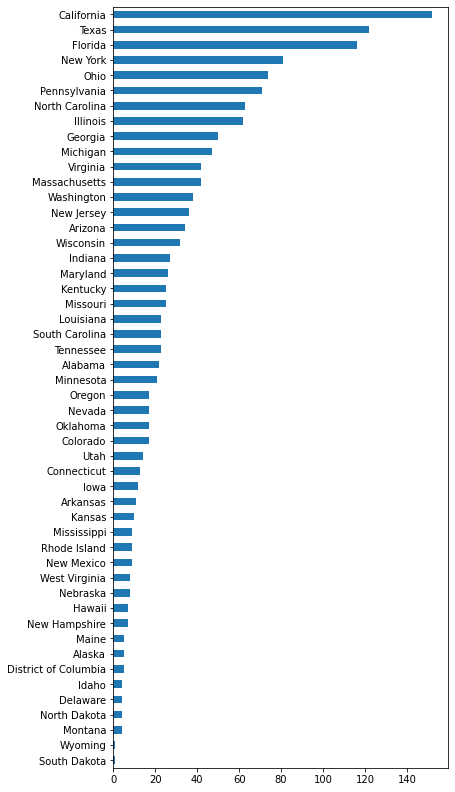

In [93]:
# Respondents by state
print('%s\n'%codebook['Q_state']['Q'])
fig,ax = plt.subplots(figsize=(6,14))
_ = sample_df['Q_state'].astype(str).value_counts().sort_values().rename(
    codebook['Q_state']['choices']).plot.barh(ax=ax)
# print(sample_df['Q_state'].value_counts().sort_values().rename(
#     codebook['Q_state']['choices']))

What is your gender?


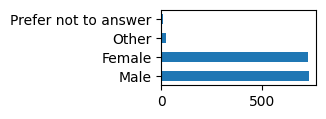

,index,count,pct
0,Male,734,49.10
1,Female,730,48.83
2,Other,24,1.61
3,Prefer not to answer,7,0.47


In [94]:
print('%s'%codebook['Q_gender']['Q'])
fig,ax = plt.subplots(figsize=(2,1), dpi=100)
_ = sample_df['Q_gender'].astype(str).value_counts().sort_index().rename(codebook['Q_gender']['choices']).plot.barh(ax=ax)
plt.show()
gender_df = (sample_df['Q_gender'].astype(str).value_counts()
          .sort_index().rename(codebook['Q_gender']['choices'])
          .to_frame(name='count').reset_index()
          .assign(pct=lambda x: round(100*x['count']/N, 2)))
gender_df

How old are you?


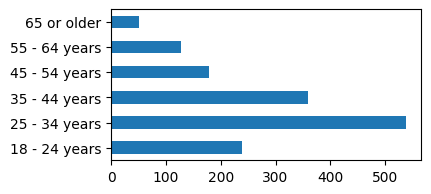

,index,count,pct
0,18 - 24 years,239,15.99
1,25 - 34 years,539,36.05
2,35 - 44 years,360,24.08
3,45 - 54 years,179,11.97
4,55 - 64 years,127,8.49
5,65 or older,51,3.41


In [95]:
print('%s'%codebook['Q_age']['Q'])
fig,ax = plt.subplots(figsize=(4,2), dpi=100)
_ = sample_df['Q_age'].astype(str).value_counts().sort_index().rename(codebook['Q_age']['choices']).plot.barh(ax=ax)
plt.show()
age_df = (sample_df['Q_age'].astype(str).value_counts()
          .sort_index().rename(codebook['Q_age']['choices'])
          .to_frame(name='count').reset_index()
          .assign(pct=lambda x: round(100*x['count']/N, 2)))
age_df

What was your total household income in the previous year before taxes?


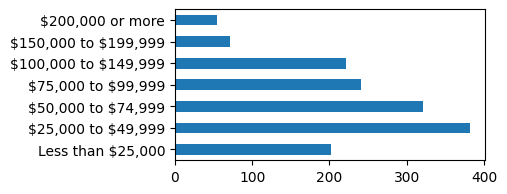

,index,count,pct
0,"Less than \$25,000",202,13.51
1,"\$25,000 to \$49,999",382,25.55
2,"\$50,000 to $74,999",321,21.47
3,"\$75,000 to \$99,999",241,16.12
4,"\$100,000 to $149,999",222,14.85
5,"\$150,000 to \$199,999",72,4.82
6,"\$200,000 or more",55,3.68


In [96]:
Q = 'Q_income'
print('%s'%codebook[Q]['Q'])
fig,ax = plt.subplots(figsize=(4,2), dpi=100)
_ = sample_df[Q].astype(str).value_counts().sort_index().rename(codebook[Q]['choices']).plot.barh(ax=ax)
plt.show()
df = (sample_df[Q].astype(str).value_counts()
          .sort_index().rename(codebook[Q]['choices'])
          .to_frame(name='count').reset_index()
          .assign(pct=lambda x: round(100*x['count']/N, 2)))
df

TODO: better handle section of multiple races

5             1
1,4,6         1
1,5           1
1,2,4,6       1
1,2,7         1
4,5           1
2,4           1
1,4,5         1
1,3,6         2
2,6           2
2,3           2
1,3,4         2
1,2,3         2
4,6           3
3             5
1,7           5
1,3           6
7            13
1,2          17
1,4          19
1,6          34
2            61
6            62
4           113
1          1139
Name: Q_race, dtype: int64


,index,count,pct
0,White,1139,76.19
1,Other,114,7.63
2,Asian,113,7.56
3,Hispanic or Latino,62,4.15
4,Black or African American,61,4.08
5,American Indian or Alaska Native,5,0.33
6,Native Hawaiian or Pacific Islander,1,0.07


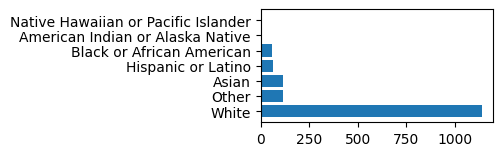

In [97]:
# Race: We put anyone who answered with 2 or more races in the 'Other' category
Q = 'Q_race'
print(sample_df[Q].value_counts().sort_values())
sample_df['race'] = (sample_df[Q]
                       .apply(lambda r: r if r in ['1','2','3','4','5','6'] else '7')
                       .map(codebook[Q]['choices']))
df = (sample_df['race'].value_counts().sort_values(ascending=False)
    .to_frame(name='count').reset_index()
    .assign(pct=lambda x: round(100*x['count']/N, 2)))
fig,ax = plt.subplots(1,1,figsize=(3,1.5),dpi=100)
_ = ax.barh(df['index'], df['count'])
df

Which best describes where you live?


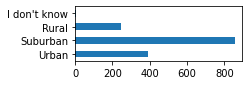

,index,count,pct
0,Urban,389,26.02
1,Suburban,854,57.12
2,Rural,245,16.39
3,I don't know,7,0.47


In [98]:
Q = 'Q_urban_rural'
print('%s'%codebook[Q]['Q'])
fig,ax = plt.subplots(figsize=(3,1))
_ = sample_df[Q].astype(str).value_counts().sort_index().rename(codebook[Q]['choices']).plot.barh(ax=ax)
plt.show()
df = (sample_df[Q].astype(str).value_counts()
          .sort_index().rename(codebook[Q]['choices'])
          .to_frame(name='count').reset_index()
          .assign(pct=lambda x: round(100*x['count']/N, 2)))
df

What type of residence do you live in?


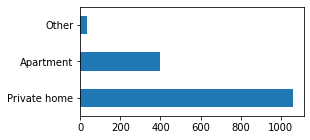

,index,count,pct
0,Private home,1061,70.97
1,Apartment,399,26.69
2,Other,35,2.34


In [99]:
Q = 'Q_residence_type'
print('%s'%codebook[Q]['Q'])
fig,ax = plt.subplots(figsize=(4,2))
_ = sample_df[Q].astype(str).value_counts().sort_index().rename(codebook[Q]['choices']).plot.barh(ax=ax)
plt.show()
df = (sample_df[Q].astype(str).value_counts()
          .sort_index().rename(codebook[Q]['choices'])
          .to_frame(name='count').reset_index()
          .assign(pct=lambda x: round(100*x['count']/N, 2)))
df

Probe distribution of answers about vendors / delivery willingness

(Not a vendor) Online shopping

(Not a studied vendor type)

How often (on average) do you make online shopping purchases?


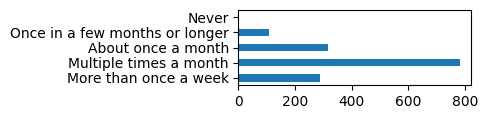

In [100]:
Q = 'Q_online_shopping'
print('(Not a studied vendor type)\n')
print('%s'%codebook[Q]['Q'])
fig,ax = plt.subplots(figsize=(3,1), dpi=100)
_ = sample_df[Q].astype(str).value_counts().sort_index().rename(codebook[Q]['choices']).plot.barh(ax=ax)
plt.show()
df = (sample_df[Q].astype(str).value_counts()
          .sort_index().rename(codebook[Q]['choices'])
          .to_frame(name='count')
          .assign(pct=lambda x: round(100*x['count']/N, 2)))
# df

v0:
How often (on average) do you have take-out food delivered to your home?


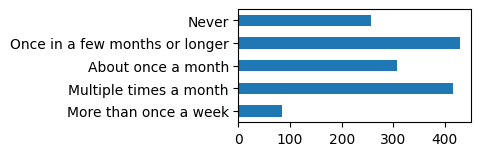

,count,pct
More than once a week,85,5.69
Multiple times a month,416,27.83
About once a month,308,20.60
Once in a few months or longer,429,28.70
Never,257,17.19


In [101]:
Q = 'Q_takeout_food'
print('v0:')
print('%s'%codebook[Q]['Q'])
fig,ax = plt.subplots(figsize=(3,1.5), dpi=100)
_ = sample_df[Q].astype(str).value_counts().sort_index().rename(codebook[Q]['choices']).plot.barh(ax=ax)
plt.show()
df = (sample_df[Q].astype(str).value_counts()
          .sort_index().rename(codebook[Q]['choices'])
          .to_frame(name='count')
          .assign(pct=lambda x: round(100*x['count']/N, 2)))
display(df)

In [102]:
vQs = {
    'online shopping (Not a studied vendor type)': 'Q_online_shopping',
    'v0': 'Q_takeout_food',
    'v1': 'Q_v_1',
    'v2': 'Q_v_2',
    'v3': 'Q_online_groceries'
}

online shopping (Not a studied vendor type):
How often (on average) do you make online shopping purchases?


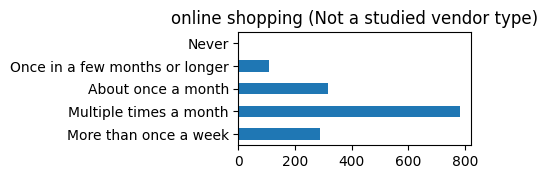

v0:
How often (on average) do you have take-out food delivered to your home?


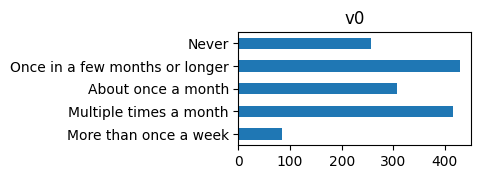

v1:
Suppose there is a company that specializes in delivering prescription medications and offers service in your area, and the total price is similar to local pharmacies. If you needed prescription medications, would you ever order them from this company for delivery to your home?


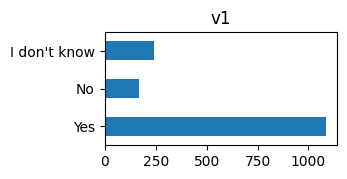

v2:
Would you ever order items from a liquor store for delivery to your home?


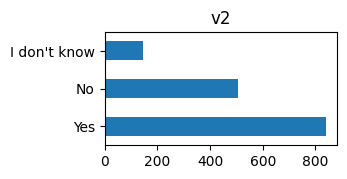

v3:
How often (on average) do you purchase your groceries online?


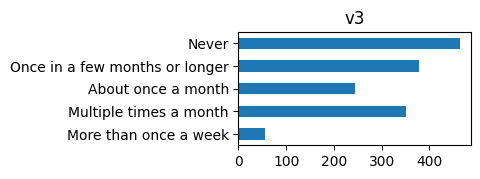

In [103]:
for v, Q in vQs.items():
    print('%s:'%v)
    print('%s'%codebook[Q]['Q'])
    fig,ax = plt.subplots(figsize=(3,1.5), dpi=100)
    _ = sample_df[Q].astype(str).value_counts().sort_index().rename(codebook[Q]['choices']).plot.barh(ax=ax)
    ax.set_title(v)
    plt.show()
    df = (sample_df[Q].astype(str).value_counts()
              .sort_index().rename(codebook[Q]['choices'])
              .to_frame(name='count')
              .assign(pct=lambda x: round(100*x['count']/N, 2)))
    #display(df)

We are concerned with the people who say they would never order X for delivery.

How many are there for each vendor type?

Who are they? Are there consistent demographic groups?

Why would they never order vX for delivery?

What are the combinations?

### v0

Takeout food

In [104]:
Q = 'Q_takeout_food'
why_no = 'Q_v_0_why_no'
# '5':'Never'
never_choice = '5'
print(codebook[Q]['Q'])
print(codebook[Q]['choices'][never_choice])
v0_never_rdf = sample_df[sample_df[Q].astype(str)==never_choice]
print('n=%s'%len(v0_never_rdf))

# why no?
print('Reason')
print('Reference:')
display(pd.DataFrame(
    [[val, reason] for val,reason in codebook_why_no['choices'].items()],
    columns=['value','reason']
).set_index('value'))
print('Responses:')
display(v0_never_rdf[why_no].value_counts().sort_values())

print('write-ins for other:')
for other_reason in v0_never_rdf['Q_v_0_why_no_4_TEXT'].dropna():
    print(other_reason)

# v0_never_rdf.head()

How often (on average) do you have take-out food delivered to your home?
Never
n=257
Reason
Reference:


,reason
value,
1,I prefer the in-store experience
2,I want to avoid potential delivery fees or add...
3,I want to avoid potential delays
4,Other


Responses:


1,2,4        1
1,2,3,4      1
2,3,4        4
3            5
1            9
1,2         12
2,4         13
1,2,3       13
2,3         28
4           69
2          102
Name: Q_v_0_why_no, dtype: int64

write-ins for other:
Most Places dont deliver to my home
Don’t think the food will be as fresh.
I live in a rural area
Eating out is too expensive plus adding on delivery fees makes it even more impractical.
I live in a rural area with no food delivery services.
The local restaurants don't provide delivery.
MAking my own food is cheaper and I don't like strange idiots handling my food
There is no service available that delivers to my area.
they dont deliver to my area
my house is too far from any restaurants
Nobody delivers to where we live
Don't have the option 
I home cook. 
It's hard for me to meet the minimum order.
We mostly cook our own food
Covid + other diseases + cheaper not too
I live in a rural area and it id not available
I live pretty far away from town so the vast majority of places do not deliver to my home.
Much rather go out than eat take-out food at home.
I do not eat restaurant food
Cold food
Food delivery apps don't deliver to where we live.
I live too far away for 

### v1 - prescription medications

In [105]:
Q = 'Q_v_1'
why_no = 'Q_v_1_why_no'
why_no_text = 'Q_v_1_why_no_4_TEXT'
# '2':'No'
never_choice = '2'
print(codebook[Q]['Q'])
print(codebook[Q]['choices'][never_choice])
v_never_rdf = sample_df[sample_df[Q].astype(str)==never_choice]
print('n=%s'%len(v_never_rdf))

# why no?
print('Reason')
print('Reference:')
display(pd.DataFrame(
    [[val, reason] for val,reason in codebook_why_no['choices'].items()],
    columns=['value','reason']
).set_index('value'))
print('Responses:')
display(v_never_rdf[why_no].value_counts().sort_values())

print('write-ins for other:')
for other_reason in v_never_rdf[why_no_text].dropna():
    print(other_reason)

# v_never_rdf.head()

Suppose there is a company that specializes in delivering prescription medications and offers service in your area, and the total price is similar to local pharmacies. If you needed prescription medications, would you ever order them from this company for delivery to your home?
No
n=166
Reason
Reference:


,reason
value,
1,I prefer the in-store experience
2,I want to avoid potential delivery fees or add...
3,I want to avoid potential delays
4,Other


Responses:


1,2       2
3,4       3
2,3,4     4
1,4       4
2,4       5
1,3       7
1,2,3    10
3        16
1        18
2,3      24
2        33
4        40
Name: Q_v_1_why_no, dtype: int64

write-ins for other:
Don’t want my meds subject to the weather if I’m not home to receive them.
privacy concerns as medication is much more personal than food
My family doesn't have any prescription medications.
I don't take any prescriptions
Theft of important medication
going in the drive thru at walgreens is not that complicated or a bother for me to do now
Privacy concerns 
I wouldn't like someone else handling my medication.
We've looked into this for our area and it's difficult to set up refills for certain meds if the refill isn't automatically approved by our doctors.
I already have automatic prescription refills set up through my regular drug store.
privacy
dont trust my medicine with strangers
My health care provider already provides this service
I already get my medications delivered to my home by a pharmacy.
I have Medical Weed I have curbside and wear a RESPIRATOR not mouth diaper
I generally have to use a certain pharmacy
I would maybe like medical advice along with the m

In [106]:
Q = 'Q_v_2'
why_no = 'Q_v_2_why_no'
why_no_text = 'Q_v_2_why_no_4_TEXT'
# '2':'No'
never_choice = '2'
print(codebook[Q]['Q'])
print(codebook[Q]['choices'][never_choice])
v_never_rdf = sample_df[sample_df[Q].astype(str)==never_choice]
print('n=%s'%len(v_never_rdf))

# why no?
print('Reason')
print('Reference:')
display(pd.DataFrame(
    [[val, reason] for val,reason in codebook_why_no['choices'].items()],
    columns=['value','reason']
).set_index('value'))
print('Responses:')
display(v_never_rdf[why_no].value_counts().sort_values())

print('write-ins for other:')
for other_reason in v_never_rdf[why_no_text].dropna():
    print(other_reason)

# v_never_rdf.head()

Would you ever order items from a liquor store for delivery to your home?
No
n=507
Reason
Reference:


,reason
value,
1,I prefer the in-store experience
2,I want to avoid potential delivery fees or add...
3,I want to avoid potential delays
4,Other


Responses:


1,2,3,4      1
3,4          1
1,2,4        3
1,3          5
3            8
1,4          9
2,4         14
1,2,3       15
2,3         22
1,2         41
1           74
2          104
4          210
Name: Q_v_2_why_no, dtype: int64

write-ins for other:
I don't do it often enough to warrant delivery
I don't drink alcohol. 
Everyone in the house is sober
I don’t drink alcohol
I don't drink.
I don't drink
I don't drink alcohol 
There aren't many services in my location that offer it
it is an unnecessary luxury
Don’t drink 
Don't drink alcohol
I don't drink alcohol
I don't drink
i dont use alcohol at all
Can’t drink, bad liver
I don't drink
I do not drink alcohol
I don't drink
Not interested in liquor
I don't drink liquor
I don’t drink. 
I don't drink
I rarely drink.
I don't drink liquor 
I don't want to risk damage to bottle from mishandling or the drink itself from possible heat exposure.
don't drink
I dont drink
I do not drink alcohol
I don't drink alcohol
I like to look at my options in person
The bottle might be destroyed in shipping
I do not drink
I don't drink
i don't drink alcohol
I don't drink alcohol.
I don't buy from liquor stores
I don't drink.
I don't drink liquor
I don't drink
I don't purchase liquor ev

In [107]:
Q = 'Q_online_groceries'
why_no = 'Q_v_3_why_no'
why_no_text = 'Q_v_3_why_no_4_TEXT'
# '5':'Never'
never_choice = '5'
print(codebook[Q]['Q'])
print(codebook[Q]['choices'][never_choice])
v_never_rdf = sample_df[sample_df[Q].astype(str)==never_choice]
print('n=%s'%len(v_never_rdf))

# We do not collect why not for the groceries

# v_never_rdf.head()

How often (on average) do you purchase your groceries online?
Never
n=464


## Choices

Data checks

Transform wide data into long data

In [108]:
# Wide data
# drop data from respondents who failed attention checks
sample_df[['ResponseId']+choice_Qs].head(3)

,ResponseId,CHOICE_v0_gc0_gt0_dc0_dt2_dp0_1,CHOICE_v0_gc0_gt0_dc1_dt0_dp1_1,CHOICE_v0_gc0_gt1_dc0_dt2_dp0_1,CHOICE_v0_gc0_gt1_dc1_dt0_dp0_1,CHOICE_v0_gc0_gt1_dc2_dt1_dp0_1,CHOICE_v0_gc0_gt1_dc2_dt1_dp1_1,CHOICE_v0_gc0_gt2_dc0_dt1_dp0_1,CHOICE_v0_gc0_gt2_dc0_dt2_dp0_1,CHOICE_v0_gc0_gt2_dc1_dt0_dp1_1,...,CHOICE_v3_gc3_gt2_dc1_dt2_dp1_1.1,CHOICE_v3_gc3_gt2_dc2_dt2_dp1_1.1,CHOICE_v3_gc3_gt2_dc3_dt0_dp1_1.1,CHOICE_v3_gc3_gt2_dc3_dt1_dp0_1.1,CHOICE_v3_gc3_gt2_dc3_dt3_dp0_1.1,CHOICE_v3_gc3_gt2_dc3_dt3_dp1_1.1,CHOICE_v3_gc3_gt3_dc2_dt3_dp0_1.1,CHOICE_v3_gc3_gt3_dc3_dt1_dp1_1.1,CHOICE_v3_gc3_gt3_dc3_dt2_dp1_1.1,CHOICE_v3_gc3_gt3_dc3_dt3_dp0_1.1
0,R_3dNdOyEHwO3X5Tg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
1,R_1r7Zvnp6IL6dFXo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,R_1JIXl9IZdC0IxJt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [109]:
# Transform the wide data to long data.
choices_df = pd.melt(
    sample_df[['ResponseId']+choice_Qs], 
    id_vars=['ResponseId'], value_vars=choice_Qs,
    var_name='QID', value_name='choice'
).dropna()
n_choices = len(choices_df)
print('n=%s choice responses' % n_choices)
choices_df.head(3)

n=14613 choice responses


,ResponseId,QID,choice
331,R_2DTxG8oxoUwagCE,CHOICE_v0_gc0_gt0_dc0_dt2_dp0_1,0
991,R_11jaEnzddsEMEAY,CHOICE_v0_gc0_gt0_dc0_dt2_dp0_1,0
2040,R_10pWH74NFrm8yXf,CHOICE_v0_gc0_gt0_dc1_dt0_dp1_1,0


In [110]:
choices_df['choice'] = choices_df['choice'].astype(int)
choices_df['v'] =  choices_df['QID'].apply(lambda QID: int(QID.split('_v')[1][0]))
choices_df['gc'] =  choices_df['QID'].apply(lambda QID: int(QID.split('_gc')[1][0]))
choices_df['gt'] =  choices_df['QID'].apply(lambda QID: int(QID.split('_gt')[1][0]))
choices_df['dc'] =  choices_df['QID'].apply(lambda QID: int(QID.split('_dc')[1][0]))
choices_df['dt'] =  choices_df['QID'].apply(lambda QID: int(QID.split('_dt')[1][0]))
choices_df['dp'] =  choices_df['QID'].apply(lambda QID: int(QID.split('_dp')[1][0]))

choices_df.head(3)

,ResponseId,QID,choice,v,gc,gt,dc,dt,dp
331,R_2DTxG8oxoUwagCE,CHOICE_v0_gc0_gt0_dc0_dt2_dp0_1,0,0,0,0,0,2,0
991,R_11jaEnzddsEMEAY,CHOICE_v0_gc0_gt0_dc0_dt2_dp0_1,0,0,0,0,0,2,0
2040,R_10pWH74NFrm8yXf,CHOICE_v0_gc0_gt0_dc1_dt0_dp1_1,0,0,0,0,1,0,1


Add values to the question parameters



In [111]:
import sys  
sys.path.insert(0, '../survey-questions')

from attributes import (
    VENDOR_TYPES, COST_LEVELS, TIME_LEVELS, DRONE_PRIVACY_LEVELS,
)
for levels in [VENDOR_TYPES, COST_LEVELS, TIME_LEVELS, DRONE_PRIVACY_LEVELS]:
    print(levels)

[('take-out food', 'take-out food'), ('prescription medications', 'prescription medications'), ('liquor store', 'items from a liquor store'), ('last-minute groceries', 'last-minute groceries')]
[[(0, '$0'), (1, '$1'), (3, '$3'), (5, '$5')], [(0, '$0'), (1, '$1'), (5, '$5'), (10, '$10')], [(0, '$0'), (1, '$1'), (3, '$3'), (5, '$5')], [(0, '$0'), (1, '$1'), (3, '$3'), (5, '$5')]]
[[(15, '15 minutes'), (20, '20 minutes'), (30, '30 minutes'), (45, '45 minutes')], [(30, '30 minutes'), (120, '2 hrs'), (360, '6 hrs'), (1440, '1 day')], [(15, '15 minutes'), (20, '20 minutes'), (30, '30 minutes'), (45, '45 minutes')], [(15, '15 minutes'), (20, '20 minutes'), (30, '30 minutes'), (45, '45 minutes')]]
[(0, 'NO privacy'), (1, 'YES privacy')]


In [112]:
choices_df['v_type'] = choices_df['v'].apply(lambda v: VENDOR_TYPES[v][0])
choices_df['g_cost'] = choices_df.apply(lambda row: COST_LEVELS[row['v']][row['gc']][0],axis=1)
choices_df['d_cost'] = choices_df.apply(lambda row: COST_LEVELS[row['v']][row['dc']][0],axis=1)
choices_df['g_time'] = choices_df.apply(lambda row: TIME_LEVELS[row['v']][row['gt']][0],axis=1)
choices_df['d_time'] = choices_df.apply(lambda row: TIME_LEVELS[row['v']][row['dt']][0],axis=1)
choices_df['d_privacy'] = choices_df.apply(lambda row: DRONE_PRIVACY_LEVELS[row['dp']][0],axis=1)
choices_df.head(3)

,ResponseId,QID,choice,v,gc,gt,dc,dt,dp,v_type,g_cost,d_cost,g_time,d_time,d_privacy
331,R_2DTxG8oxoUwagCE,CHOICE_v0_gc0_gt0_dc0_dt2_dp0_1,0,0,0,0,0,2,0,take-out food,0,0,15,30,0
991,R_11jaEnzddsEMEAY,CHOICE_v0_gc0_gt0_dc0_dt2_dp0_1,0,0,0,0,0,2,0,take-out food,0,0,15,30,0
2040,R_10pWH74NFrm8yXf,CHOICE_v0_gc0_gt0_dc1_dt0_dp1_1,0,0,0,0,1,0,1,take-out food,0,1,15,15,1


What was the distribution of the number of choice questions across the vendor types?

Make a table and plot.

```
v, n, %
```

,vendor,n,%
v,,,
0,take-out food,3930,26.89
1,prescription medications,4482,30.67
2,liquor store,3000,20.53
3,last-minute groceries,3201,21.91


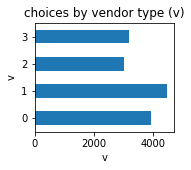

In [113]:
n_choices_v_df = (
    pd.DataFrame({
        'v':list(range(len(VENDOR_TYPES))),
        'vendor': [v[0] for v in VENDOR_TYPES],
        'n': [len(choices_df[choices_df['v']==v]) for v in range(len(VENDOR_TYPES))],
    }).assign(pct=lambda x: round(100*x['n']/n_choices, 2))
    .rename({'pct':'%'},axis=1)
    .set_index('v')
)
fig,ax = plt.subplots(figsize=(2.5,2))
n_choices_v_df['n'].plot.barh(ax=ax)
ax.set_xlabel('n')
ax.set_xlabel('v')
ax.set_title('choices by vendor type (v)')

n_choices_v_df

### Plotting

In [144]:
# add in extra for evaluating trade-offs
choices_df['d_time - g_time'] = choices_df['d_time'] - choices_df['g_time']
choices_df['d_cost - g_cost'] = choices_df['d_cost'] - choices_df['g_cost']
choices_df.head(3)

,ResponseId,QID,choice,v,gc,gt,dc,dt,dp,v_type,g_cost,d_cost,g_time,d_time,d_privacy,d_time - g_time,d_cost - g_cost
331,R_2DTxG8oxoUwagCE,CHOICE_v0_gc0_gt0_dc0_dt2_dp0_1,0,0,0,0,0,2,0,take-out food,0,0,15,30,0,15,0
991,R_11jaEnzddsEMEAY,CHOICE_v0_gc0_gt0_dc0_dt2_dp0_1,0,0,0,0,0,2,0,take-out food,0,0,15,30,0,15,0
2040,R_10pWH74NFrm8yXf,CHOICE_v0_gc0_gt0_dc1_dt0_dp1_1,0,0,0,0,1,0,1,take-out food,0,1,15,15,1,0,1


In [ ]:
color_ground = 'blue'
color_drone = 'red'

In [145]:

def plot_points_tradeoff_by_size(df, vendor):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=200)
    for dp, privacy in enumerate(DRONE_PRIVACY_LEVELS):
        ax = axes[dp]
        df_p = df[df['dp']==dp]
        df_p_agg = df_p[df_p['choice']==0].groupby(
            ['d_time - g_time','d_cost - g_cost']
        )['ResponseId'].count().rename('ground').to_frame()
        df_p_agg['drone'] = df_p_agg.index.map(df_p[df_p['choice']==1].groupby(
            ['d_time - g_time','d_cost - g_cost']
        )['ResponseId'].count())
        df_p_agg = df_p_agg.reset_index()
        ax.scatter(
            df_p_agg['d_time - g_time'],
            df_p_agg['d_cost - g_cost'],
            df_p_agg['ground'],
            color=color_ground, alpha=0.5, label='choice: ground vehicle',
            marker='o',
        )
        ax.scatter(
            df_p_agg['d_time - g_time'],
            df_p_agg['d_cost - g_cost'],
            df_p_agg['drone'],
            color=color_drone, alpha=0.5, label='choice: drone',
            marker='o',
        )   
        ax.set_xlabel('drone wait time - ground vehicle wait time (mins)')
        ax.set_ylabel('drone cost - ground vehicle cost (\$)')
        ax.axvline(c='grey', lw=1)
        _ = ax.axhline(c='grey', lw=1)
        _ = ax.set_title(privacy[1])
        ax.legend()
    title = ('%s: Ground vehicle vs Drone choice differences w.r.t. cost and time' % vendor)
    _ = fig.suptitle(title)

In [146]:
def plot_points_tradeoff(df, vendor):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=200)
    for dp, privacy in enumerate(DRONE_PRIVACY_LEVELS):
        ax = axes[dp]
        df_p = df[df['dp']==dp]
        df_p_choice_ground = df_p[df_p['choice'] == 0]
        df_p_choice_drone = df_p[df_p['choice'] == 1]
        ax.scatter(
            df_p_choice_ground['d_time - g_time'],
            df_p_choice_ground['d_cost - g_cost'],
            color=color_ground, alpha=0.5, label='choice: ground vehicle',
            marker='o',
        )
        ax.scatter(
            df_p_choice_drone['d_time - g_time'],
            df_p_choice_drone['d_cost - g_cost'],
            color=color_drone, alpha=0.5, label='choice: drone',
            marker='o',
        )   
        ax.set_xlabel('drone wait time - ground vehicle wait time (mins)')
        ax.set_ylabel('drone cost - ground vehicle cost (\$)')
        ax.axvline(c='grey', lw=1)
        _ = ax.axhline(c='grey', lw=1)
        _ = ax.set_title(privacy[1])
        ax.legend()
    title = ('%s: Ground vehicle vs Drone choice differences w.r.t. cost and time' % vendor)
    _ = fig.suptitle(title)

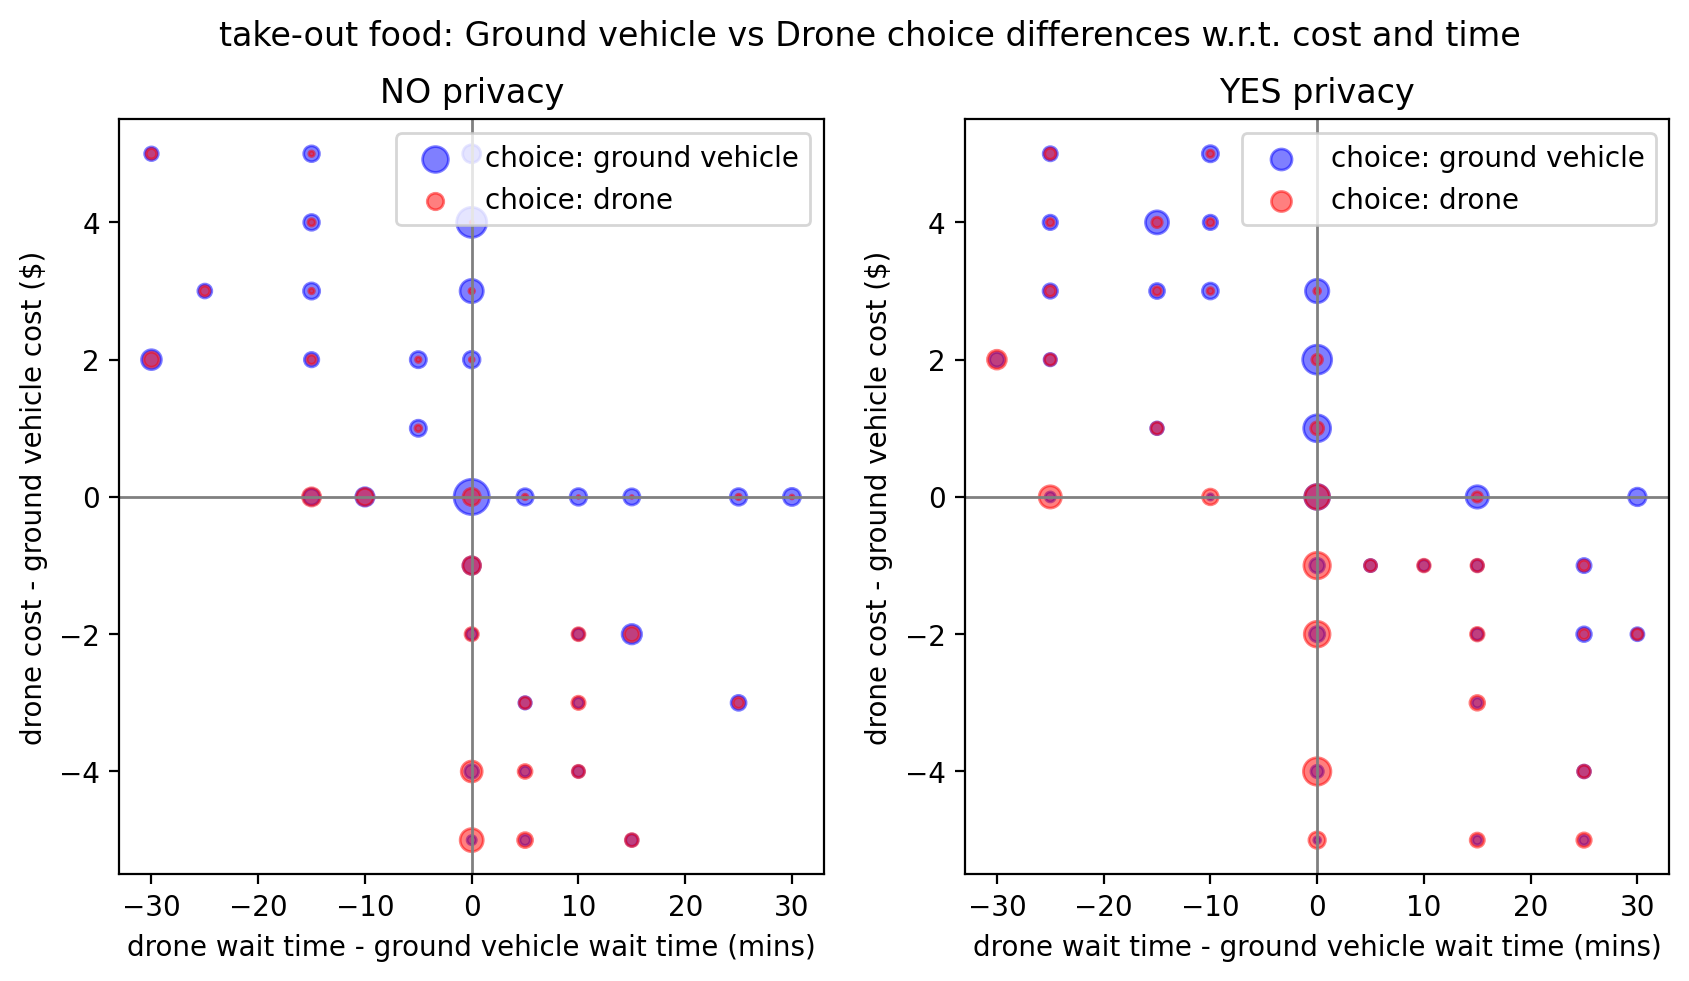

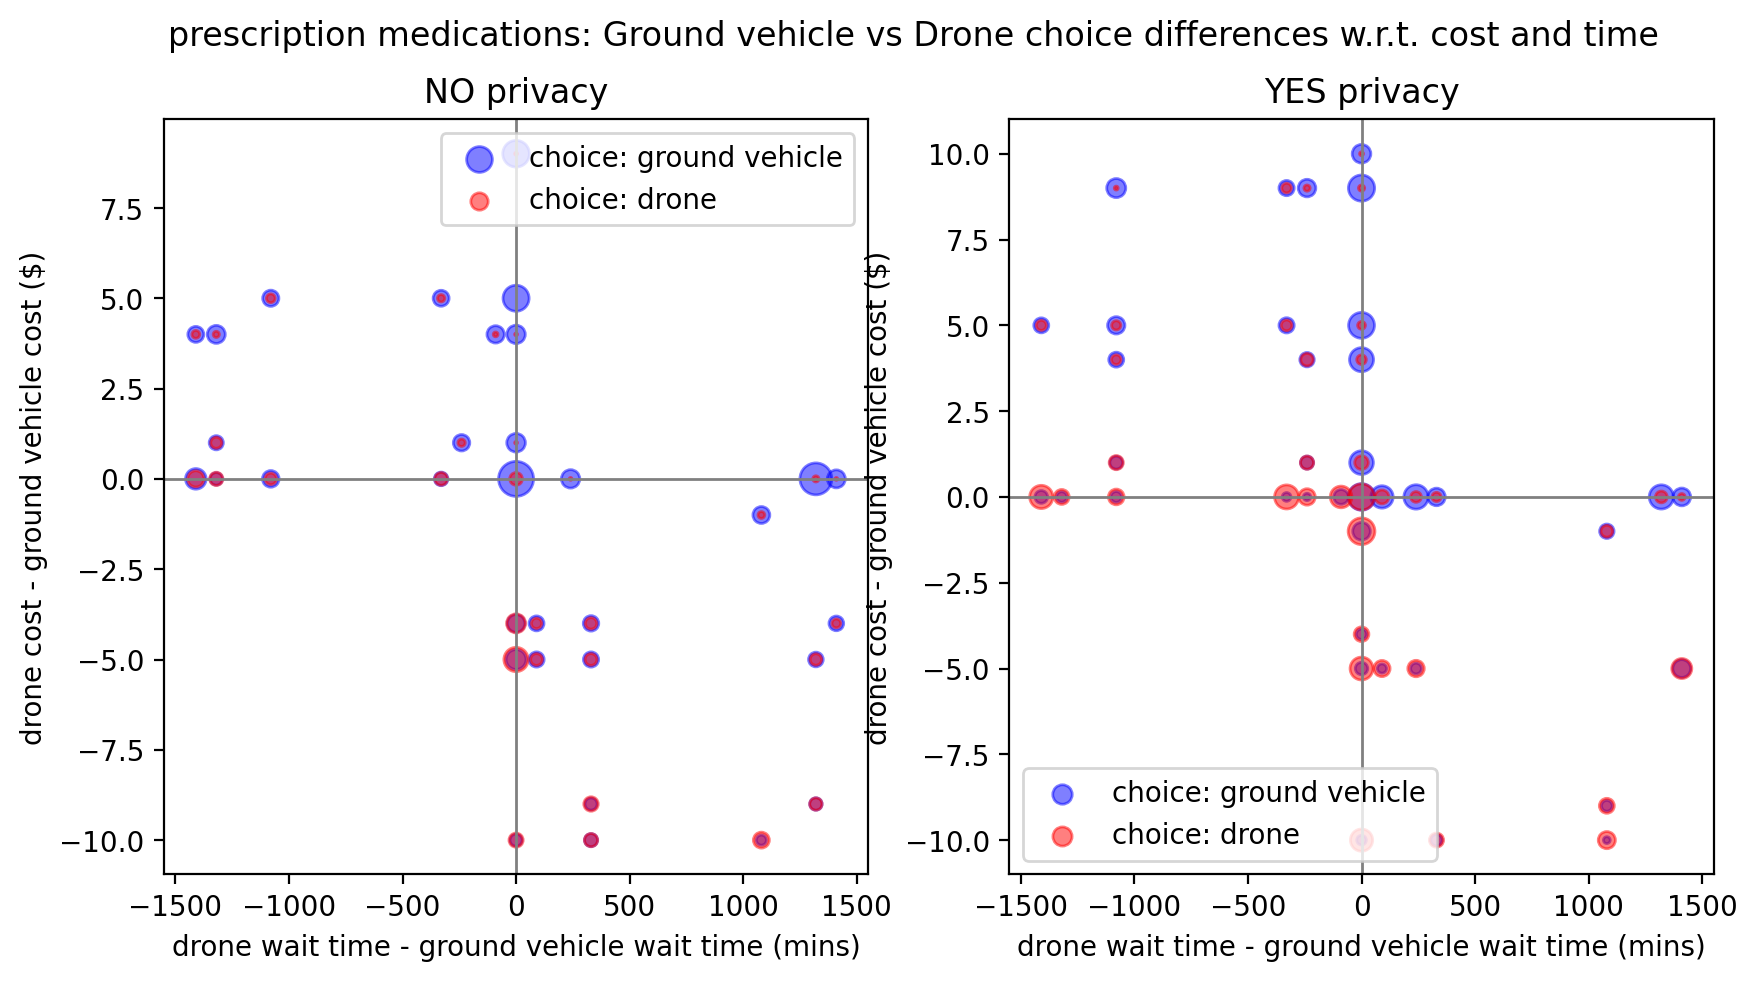

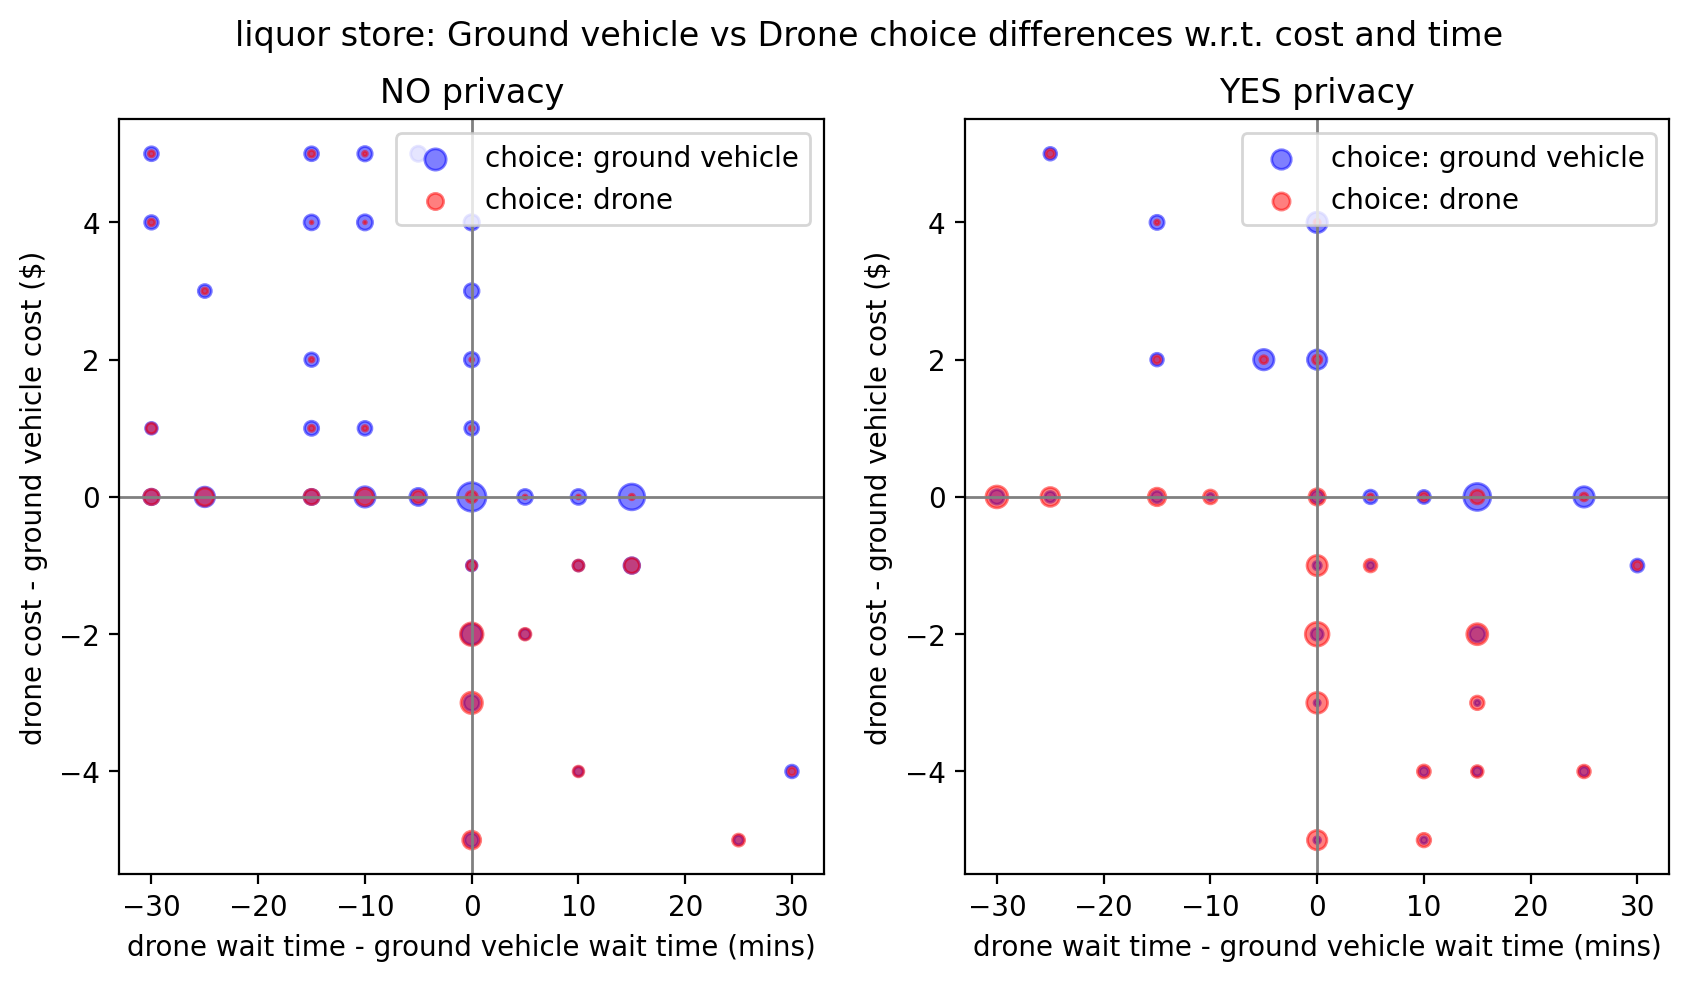

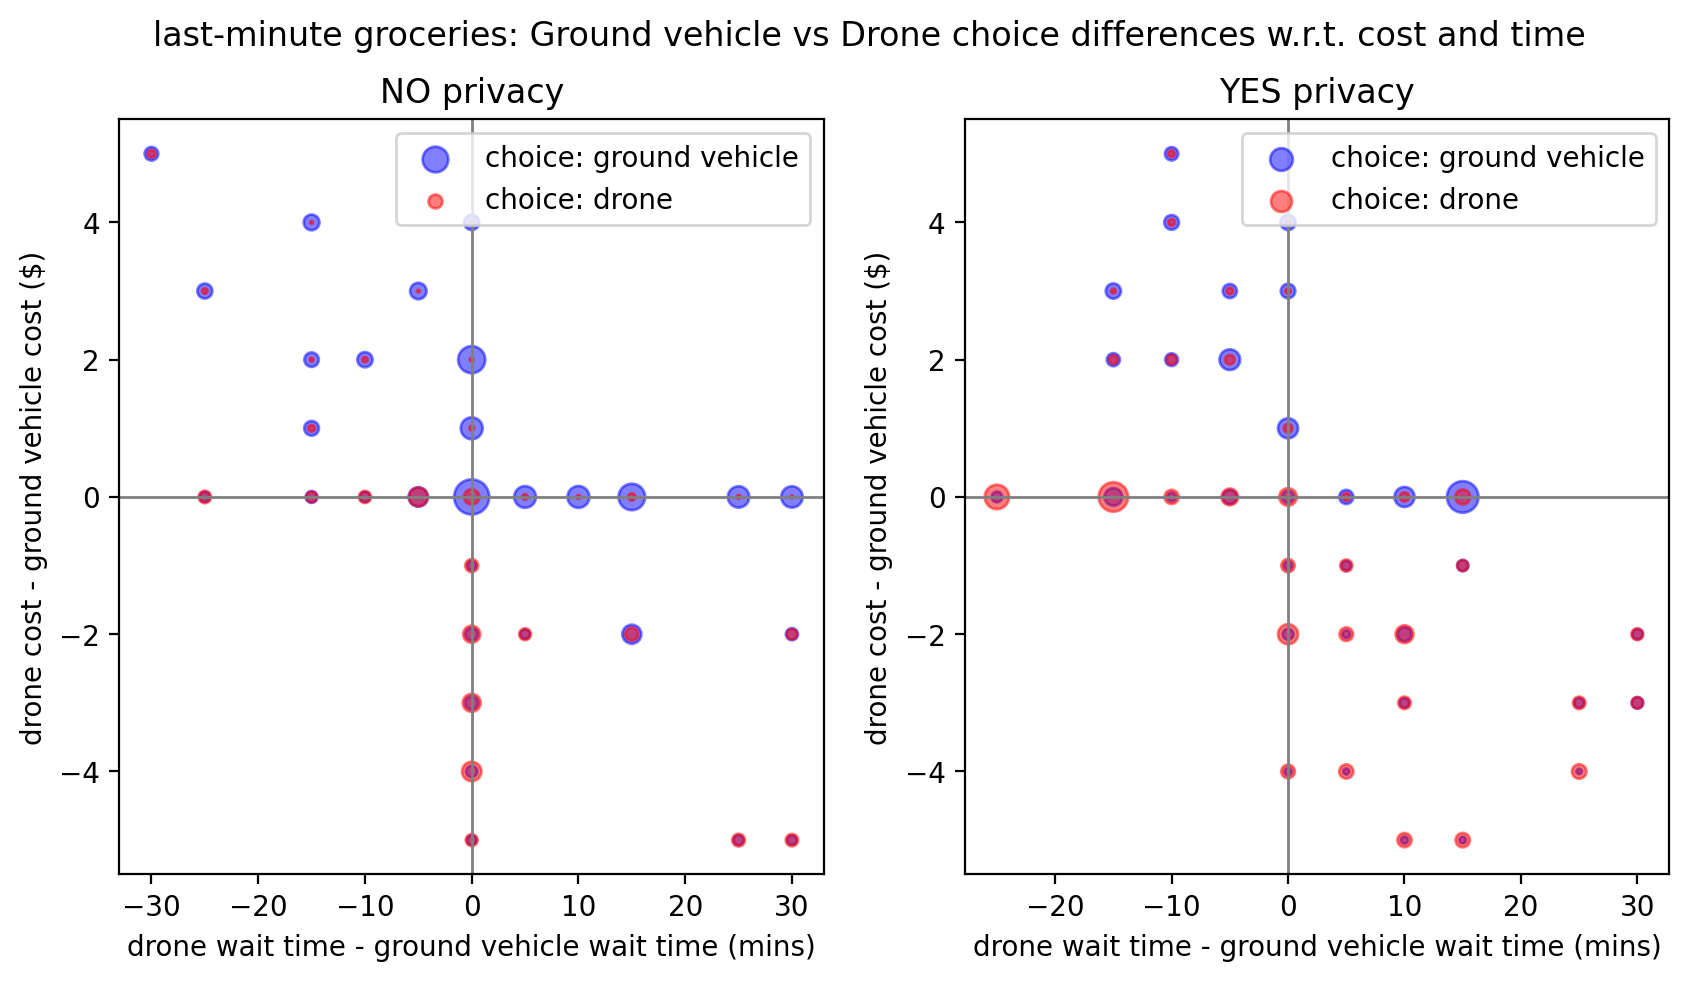

In [148]:
for v, vendor_type in enumerate(VENDOR_TYPES):
    vdf = choices_df[choices_df['v']==v]
    plot_points_tradeoff_by_size(vdf, vendor_type[0])